In [13]:
from Bio.PDB import PDBParser
import pandas as pd
import re
import os
import subprocess

# import from ../utils.py
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import get_dbref_data

## 1. simple visualisation (network and cartoon) 
### still need to simplify

In [14]:
from matplotlib import pyplot as plt
import pickle

def get_ca_coordinates(pdb_file):
    # get x, y, z coordinates of alpha carbon atoms
    parser = PDBParser()
    structure = parser.get_structure("pdb_structure", pdb_file)
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_id()[0] == ' ':
                    for atom in residue:
                        if atom.get_id() == 'CA':
                            coords = atom.get_coord()
                            ca_atoms.append({
                                'residue_number': residue.id[1],
                                'amino_acid': residue.resname,
                                'chain': chain.id,
                                'x': coords[0],
                                'y': coords[1],
                                'z': coords[2],
                            })
    return ca_atoms

def get_res_info(res):
    def check_residue_format(string):
        # Define the pattern for the format "<3letteraa><res_num><chain>"
        pattern = r'^[a-zA-Z]{3}\d+[a-zA-Z]$'
        
        # Check if the string matches the pattern
        if re.match(pattern, string):
            return True
        else:
            return False
    aas, res_nums, chains = [], [], []
    for r in res:
        # should have format "<3letteraa><res_num><chain>"
        if not check_residue_format(r):
            print()
            aas.append("NA")
            res_nums.append("NA")
            chains.append("NA")
            continue
        # get amino acid, residue number and chain
        aas.append(r[:3])
        res_nums.append(int(r[3:-1]))
        chains.append(r[-1])
    return aas, res_nums, chains



def save_palette_img(filename, palette, binvalues, score_name):
    """
    Print and display the generated color palette.

    Parameters:
    palette (list): List of RGB tuples representing the color palette.
    """
    fig, ax = plt.subplots(figsize=(10, 1), nrows=1, ncols=1)
    for idx, color in enumerate(palette):
        ax.add_patch(plt.Rectangle((idx, 0), 1, 0.5, color=color))
    
    ax.set_xlim(0, len(palette))
    ax.set_ylim(0, 0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    score_name = score_name.replace("_", " ").title()
    ax.set_title(score_name, pad=20)
    # title fontsize
    ax.title.set_fontsize(20)

    # add bin values
    for idx, val in enumerate(binvalues):
        ax.text(idx+0, 0.65, f"{val:.2f}", color='black', ha='center', va='center', fontsize=8)

    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()


In [15]:
def create_pymol_script(score_file_path, pdb_id, score_name, palette="RdBu", chain_col=0, site_col=1, score_col=2, reverse_color=True, meaningful_zero=True):
    """
    Create a PyMOL script to visualize the protein structure with the calculated scores.
    """

    pdb_file_path = f"../pdb_files/{pdb_id}.pdb"
    ca_coordinates = pd.DataFrame(get_ca_coordinates(pdb_file_path))
    ca_coordinates['foo_name'] = ["foo"+str(i) for i in range(1, len(ca_coordinates) + 1)]
    ca_coordinates['atom_name'] = ["atom"+str(i) for i in range(1, len(ca_coordinates) + 1)]

    out = "bg_color grey30\n"
    for _, row in ca_coordinates.iterrows():
        out += f"pseudoatom {row['foo_name']}, pos=[{row['x']}, {row['y']}, {row['z']}], name={row['atom_name']}\n"
        out += f"set grid_slot, 1, {row['foo_name']}\n"
        out += f"set grid_slot, 1, {row['atom_name']}\n"

    with open (f"../sbna_results/{pdb_id}/A/{pdb_id}_multimer/Centroid/{pdb_id}_multimer_nowaters_centroidNetSC", "r") as f:
        res1 = []
        res2 = []
        dist = []
        for line in f:
            res1.append(line.split()[0])
            res2.append(line.split()[1])
            dist.append(line.split()[-1])
    tmp = pd.DataFrame()
    tmp['res1'] = res1
    tmp['res2'] = res2
    tmp['dist'] = dist

    # --> there are duplicates where res1 and res2 are just swapped

    # Create a new column with sorted node pairs
    tmp['sorted_nodes'] = tmp.apply(lambda row: sorted([row['res1'], row['res2']]), axis=1)
    tmp.drop_duplicates(subset='sorted_nodes', inplace=True) # Drop duplicates based on sorted node pairs
    tmp = tmp.drop(columns=['sorted_nodes']).reset_index(drop=True)

    tmp['aa1'], tmp['res_num1'], tmp['chain1'] = get_res_info(tmp['res1'])
    tmp['aa2'], tmp['res_num2'], tmp['chain2'] = get_res_info(tmp['res2'])

    tmp = tmp.merge(ca_coordinates, left_on=['res_num1', 'aa1', 'chain1'], right_on=['residue_number', 'amino_acid', 'chain'], how='left')
    tmp.rename(columns={'x': 'x1', 'y': 'y1', 'z': 'z1', 'foo_name': 'foo_name1', 'atom_name': 'atom_name1'}, inplace=True)

    tmp = tmp.merge(ca_coordinates, left_on=['res_num2', 'aa2', 'chain2'], right_on=['residue_number', 'amino_acid', 'chain'], how='left')
    tmp.rename(columns={'x': 'x2', 'y': 'y2', 'z': 'z2', 'foo_name': 'foo_name2', 'atom_name': 'atom_name2'}, inplace=True)

    count = 1

    for _, row in tmp.iterrows():
        bond = "b"+str(count)
        out += f"create {bond}, {row['foo_name1']} or {row['foo_name2']}\n"
        out += f"bond {bond}////{row['atom_name1']}, {bond}////{row['atom_name2']}\n"
        out += f"set grid_slot, 1, {bond}\n"
        count += 1

    out += "remove resn HOH\n"
    out += 'delete '
    for i in ca_coordinates['foo_name']:
        out += i + ' or '
    out = out[:-3]
    out += '\n'
    
    out += "set grid_mode, 1\n"
    out += f"fetch {pdb_id}\n"
    out += f"set grid_slot, 2, {pdb_id}\n"

    out += f"copy {pdb_id}_copy, {pdb_id}\n"
    out += f"set grid_slot, 1, {pdb_id}_copy\n"

    out += f"hide everything, {pdb_id}_copy\n"
    out += f"show spheres, name ca and {pdb_id}_copy\nset sphere_scale, 0.25, (all)\n"

    out += f"show cartoon, {pdb_id}_copy\n"
    out += f"set cartoon_transparency, 0.85, {pdb_id}_copy\n"

    cmd = f"python pdb_color_generic_v3.py -c {str(score_col)} -d , -i {score_file_path} -l {palette} --site-column {str(site_col)} "
    if chain_col:
        cmd += f"--chain-column {str(chain_col)} "
    if not meaningful_zero:
        cmd += "-z "
    if reverse_color:
        cmd += "-r "
    
    script_args = cmd.strip().split(' ')
    out += subprocess.run(script_args, capture_output=True, text=True).stdout

    # read palette file
    with open('palette.pkl', 'rb') as file:
        palette = pickle.load(file)
    save_palette_img(f"data/{pdb_id}_palette_network_score.png", palette[0], palette[1], score_name)

    # recolour bonds, since they are overwritten by the pdb_color_generic script
    count = 1
    for _, row in tmp.iterrows():
        bond = "b"+str(count)
        out += f"color grey50, {bond}\n"
        count += 1

    return out

c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6715.
  warnings.warn(
c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6716.
  warnings.warn(
c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6717.
  warnings.warn(
c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6718.
  warnings.warn(
c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6719.
  warnings.warn(
c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is d

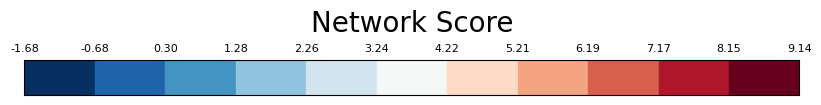

In [12]:
pdb_id = "2OCJ"
score_name = "network_score"

ns_data = pd.read_csv("../lung_cancer/lung_genes_sbna.csv")
ns_data = ns_data[ns_data['pdb_id']==pdb_id]
score_filepath = f"data/{pdb_id}_{score_name}.csv"
ns_data = ns_data[ns_data['uniprot_num']!="?"]
ns_data['uniprot_num'] = ns_data['uniprot_num'].astype(int)
ns_data = ns_data[['chain', 'uniprot_num', score_name]].sort_values(['chain', 'uniprot_num'])
ns_data.to_csv(score_filepath, index=False) # save a temporary score file
script = create_pymol_script(score_filepath, pdb_id, score_name, reverse_color=True, meaningful_zero=False)

# write script to file
with open(f"scripts/{pdb_id}_{score_name}.pml", "w") as f:
    f.write(script)

# delete the score file
# os.remove(score_filepath)

# delete all .cif files in the directory
files = [f for f in os.listdir("scripts/") if f.endswith(".cif")]
for f in files:
    os.remove("scripts/"+f)

## WT and mut comparison (it works!!!)

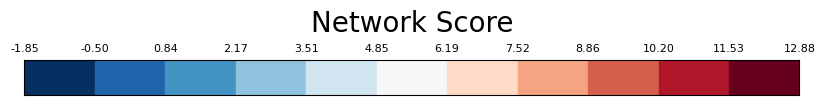

In [17]:
# create a dynamic script that takes in multiple pdbs
score_name = "network_score"

pdbs = ["2OCJ", "4IBQ", "4IBS"]
aligned_chain = ["A","C","C"] # how chains are aligned

score_filepath = f"data/{score_name}.csv"
ns_data = pd.read_csv("../lung_cancer/lung_genes_sbna.csv")
ns_data = ns_data[ns_data['pdb_id'].isin(pdbs)]
ns_data = ns_data[ns_data['uniprot_num']!="?"]
ns_data['uniprot_num'] = ns_data['uniprot_num'].astype(int)
ns_data = ns_data[['pdb_id', 'chain', 'uniprot_num', score_name]].sort_values(['pdb_id', 'chain', 'uniprot_num'])
ns_data.to_csv(score_filepath, index=False) # save a temporary score file

out = f"""bg_color grey30
set grid_mode, 1
"""

for pdb in pdbs:
    out += f"fetch {pdb}\n"

for pdb, chain in zip(pdbs, aligned_chain):
    out += f"align (chain {chain} & {pdb}), (chain {aligned_chain[0]} & {pdbs[0]})\n"
out += f"zoom (chain {chain} & {pdb})\n"

out += "remove resn HOH\n"

script_args = f"python pdb_color_generic_v4_comparison.py -c 3 -d , -i {score_filepath} -l RdBu -r -z --pdb-column 0 --chain-column 1 --site-column 2".split(' ')
out += subprocess.run(script_args, capture_output=True, text=True).stdout

# write script to file
with open(f"scripts/{"_".join(pdbs)}_{score_name}.pml", "w") as f:
    f.write(out)

# read palette file and save the colour scale
with open('palette.pkl', 'rb') as file:
    palette = pickle.load(file)
save_palette_img(f"data/{"_".join(pdbs)}_palette_{score_name}.png", palette[0], palette[1], score_name)

# delete the score file
os.remove(score_filepath)

# delete all .cif files in the directory
files = [f for f in os.listdir("scripts/") if f.endswith(".cif")]
for f in files:
    os.remove("scripts/"+f)

